load the data

In [2]:
import pandas as pd
import numpy as np

# Load datasets
train_df = pd.read_csv("./data/train.csv")
valid_df = pd.read_csv("./data/valid.csv")
test_df = pd.read_csv("./data/test.csv")

# Clean string columns: strip whitespace
def clean_strings(df):
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.strip()
    return df

train_df = clean_strings(train_df)
valid_df = clean_strings(valid_df)
test_df = clean_strings(test_df)

# Rename target column for consistency
train_df.rename(columns={"income": "label"}, inplace=True)
valid_df.rename(columns={"income": "label"}, inplace=True)
test_df.rename(columns={"income": "label"}, inplace=True)

# Separate features and labels
train_X, train_y = train_df.drop(columns=["label"]), train_df["label"]
valid_X, valid_y = valid_df.drop(columns=["label"]), valid_df["label"]
test_X, test_y = test_df.drop(columns=["label"]), test_df["label"]

In [13]:
# Read the CSV file
df = pd.read_csv('./output/prediction_a.csv')

# Remove the first row
pred_y = df['prediction']


In [14]:
pred_y

0        <=50K
1        <=50K
2         >50K
3         >50K
4        <=50K
         ...  
15055    <=50K
15056    <=50K
15057     >50K
15058    <=50K
15059     >50K
Name: prediction, Length: 15060, dtype: object

In [12]:
test_y

0        <=50K
1        <=50K
2         >50K
3         >50K
4        <=50K
         ...  
15055    <=50K
15056    <=50K
15057    <=50K
15058    <=50K
15059     >50K
Name: label, Length: 15060, dtype: object

In [15]:
acc = np.sum(pred_y == test_y) / len(test_y)

In [16]:
acc

0.7628154050464807

In [18]:
import math
import numpy as np
from collections import Counter

# ---------- Node definition ----------
class TreeNode:
    def __init__(self, is_leaf=False, prediction=None, split_attr=None, split_value=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.split_attr = split_attr
        self.split_value = split_value  # Used for numeric splits
        self.children = {}  # key → TreeNode

# ---------- Helper functions ----------
def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def mutual_info(y, attr_col):
    base_entropy = entropy(y)
    values = np.unique(attr_col)
    split_entropy = 0
    for v in values:
        subset_y = y[attr_col == v]
        if len(subset_y) == 0:
            continue
        split_entropy += (len(subset_y) / len(y)) * entropy(subset_y)
    return base_entropy - split_entropy

def best_split(X, y):
    best_gain = -1
    best_attr = None
    best_val = None

    for col in X.columns:
        if X[col].dtype == 'object':
            gain = mutual_info(y, X[col])
            if gain > best_gain:
                best_gain = gain
                best_attr = col
                best_val = None  # categorical attribute
        else:
            median = X[col].median()
            split_col = X[col] > median
            gain = mutual_info(y, split_col)
            if gain > best_gain:
                best_gain = gain
                best_attr = col
                best_val = median  # numeric attribute

    return best_attr, best_val

def majority_class(y):
    return y.value_counts().idxmax() if len(y) > 0 else None

# ---------- Tree builder ----------
def build_tree(X, y, depth=0, max_depth=10):
    if len(set(y)) == 1:
        return TreeNode(is_leaf=True, prediction=y.iloc[0])
    
    if depth == max_depth or len(X.columns) == 0:
        return TreeNode(is_leaf=True, prediction=majority_class(y))

    split_attr, split_val = best_split(X, y)
    if split_attr is None:
        return TreeNode(is_leaf=True, prediction=majority_class(y))

    node = TreeNode(is_leaf=False, split_attr=split_attr, split_value=split_val)

    if split_val is None:
        # Categorical attribute
        for val in X[split_attr].unique():
            idx = X[split_attr] == val
            if idx.sum() == 0:
                continue
            child = build_tree(X[idx].drop(columns=[split_attr]), y[idx], depth + 1, max_depth)
            node.children[val] = child
    else:
        # Numeric attribute: binary split
        left_idx = X[split_attr] <= split_val
        right_idx = X[split_attr] > split_val

        if left_idx.sum() == 0 or right_idx.sum() == 0:
            return TreeNode(is_leaf=True, prediction=majority_class(y))

        node.children['<='] = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
        node.children['>'] = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)

    return node

# ---------- Prediction ----------
def predict_single(x, node):
    while not node.is_leaf:
        val = x[node.split_attr]
        if node.split_value is None:
            # Categorical
            if val in node.children:
                node = node.children[val]
            else:
                return node.prediction  # Unknown category
        else:
            # Numeric
            key = '>' if val > node.split_value else '<='
            node = node.children[key]
    return node.prediction

def predict(X, tree):
    return X.apply(lambda x: predict_single(x, tree), axis=1)


Training tree with max depth = 5
Train Accuracy: 0.8669, Test Accuracy: 0.8062
Training tree with max depth = 10
Train Accuracy: 0.9393, Test Accuracy: 0.7756
Training tree with max depth = 15
Train Accuracy: 0.9898, Test Accuracy: 0.7636
Training tree with max depth = 20
Train Accuracy: 0.9983, Test Accuracy: 0.7628


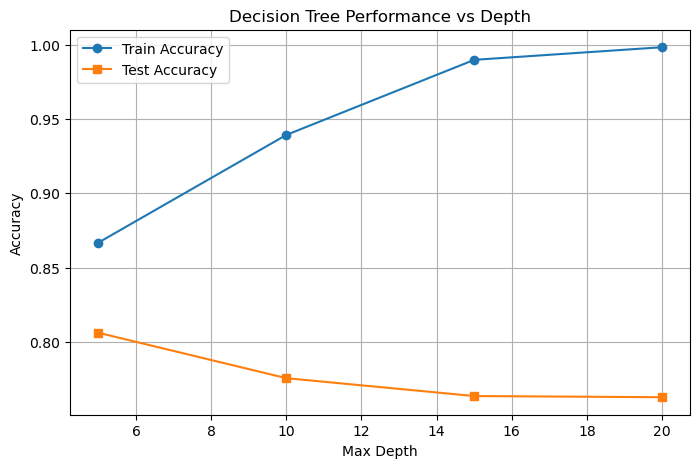

In [9]:
import matplotlib.pyplot as plt

depths = [5, 10, 15, 20]
train_accuracies = []
test_accuracies = []

for depth in depths:
    print(f"Training tree with max depth = {depth}")
    tree = build_tree(train_X, train_y, max_depth=depth)
    
    train_preds = predict(train_X, tree)
    test_preds = predict(test_X, tree)
    
    train_acc = np.mean(train_preds == train_y)
    test_acc = np.mean(test_preds == test_y) 
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Plotting
plt.figure(figsize=(8,5))
plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Performance vs Depth')
plt.legend()
plt.grid(True)
plt.show()


One hot encoding

In [5]:
# Combine all datasets temporarily for consistent encoding
combined = pd.concat([train_X, valid_X, test_X], keys=['train', 'valid', 'test'])

# One-hot encode all categorical columns (with >2 categories)
combined_encoded = pd.get_dummies(combined)

# Split back into individual sets
train_X_encoded = combined_encoded.xs('train')
valid_X_encoded = combined_encoded.xs('valid')
test_X_encoded = combined_encoded.xs('test')


In [11]:
import matplotlib.pyplot as plt

depths_b = [25, 35, 45, 55]
train_accuracies_b = []
test_accuracies_b = []

for depth in depths_b:
    print(f"Training one-hot encoded tree with max depth = {depth}")
    tree = build_tree(train_X_encoded, train_y, max_depth=depth)

    train_preds = predict(train_X_encoded, tree)
    test_preds = predict(test_X_encoded, tree)

    train_acc = np.mean(train_preds == train_y)
    test_acc = np.mean(test_preds == test_y)

    train_accuracies_b.append(train_acc)
    test_accuracies_b.append(test_acc)

    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


Training one-hot encoded tree with max depth = 25
Train Accuracy: 0.9504, Test Accuracy: 0.8175
Training one-hot encoded tree with max depth = 35
Train Accuracy: 0.9803, Test Accuracy: 0.8100
Training one-hot encoded tree with max depth = 45
Train Accuracy: 0.9941, Test Accuracy: 0.8067
Training one-hot encoded tree with max depth = 55
Train Accuracy: 0.9986, Test Accuracy: 0.8068


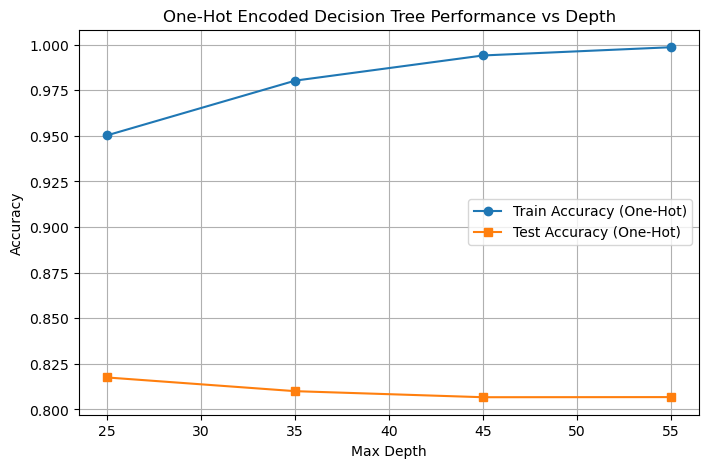

In [13]:
plt.figure(figsize=(8,5))
plt.plot(depths_b, train_accuracies_b, marker='o', label='Train Accuracy (One-Hot)')
plt.plot(depths_b, test_accuracies_b, marker='s', label='Test Accuracy (One-Hot)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('One-Hot Encoded Decision Tree Performance vs Depth')
plt.legend()
plt.grid(True)
plt.show()


pruning


In [14]:
def is_leaf(node):
    return node.is_leaf

def get_internal_nodes(node, path=()):
    """Recursively collect all internal (non-leaf) nodes in the tree."""
    if node.is_leaf:
        return []
    nodes = [(path, node)]
    for key, child in node.children.items():
        nodes += get_internal_nodes(child, path + (key,))
    return nodes

def get_node_by_path(node, path):
    """Retrieve a node given its path (sequence of keys)."""
    for key in path:
        node = node.children[key]
    return node

def prune_node(node):
    """Convert internal node to leaf using majority of its subtree labels."""
    node.is_leaf = True
    node.split_attr = None
    node.split_value = None
    node.children = {}
    node.prediction = node.prediction  # Keep previous prediction (already majority at build time)


In [15]:
def post_prune(tree, X_val, y_val):
    """Post-prune the tree using validation set accuracy."""
    best_acc = np.mean(predict(X_val, tree) == y_val)
    acc_list = [best_acc]
    node_counts = [count_nodes(tree)]

    while True:
        pruned = False
        candidates = get_internal_nodes(tree)

        for path, node in candidates:
            parent = get_node_by_path(tree, path[:-1]) if path else None
            backup = node.children.copy(), node.split_attr, node.split_value, node.is_leaf

            # Prune node
            node.is_leaf = True
            node.children = {}
            node.split_attr = None
            node.split_value = None
            node.prediction = majority_class(y_val)

            new_acc = np.mean(predict(X_val, tree) == y_val)
            if new_acc >= best_acc:
                best_acc = new_acc
                acc_list.append(best_acc)
                node_counts.append(count_nodes(tree))
                pruned = True
                break  # restart pruning loop

            # Undo prune
            node.children, node.split_attr, node.split_value, node.is_leaf = backup

        if not pruned:
            break  # No more beneficial pruning

    return acc_list, node_counts

def count_nodes(node):
    """Count total nodes in tree (used for plotting)."""
    if node.is_leaf:
        return 1
    return 1 + sum(count_nodes(child) for child in node.children.values())



Post-pruning tree with initial max depth 25

Post-pruning tree with initial max depth 35

Post-pruning tree with initial max depth 45

Post-pruning tree with initial max depth 55


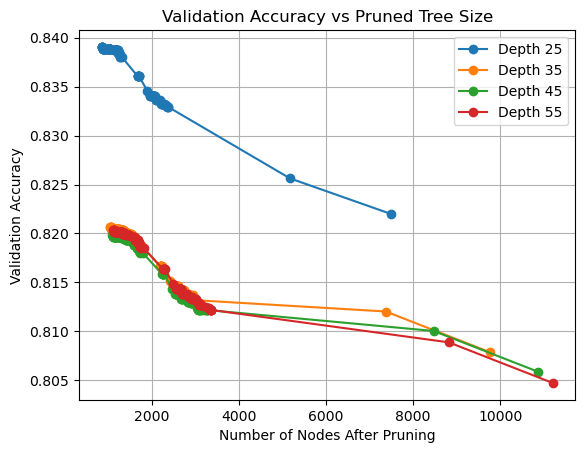

In [16]:
depths_c = [25, 35, 45, 55]
for depth in depths_c:
    print(f"\nPost-pruning tree with initial max depth {depth}")
    tree = build_tree(train_X_encoded, train_y, max_depth=depth)
    accs, nodes = post_prune(tree, valid_X_encoded, valid_y)

    plt.plot(nodes, accs, marker='o', label=f'Depth {depth}')

plt.xlabel("Number of Nodes After Pruning")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Pruned Tree Size")
plt.grid(True)
plt.legend()
plt.show()


sklearn

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [26]:
depths_d = [25, 35, 45, 55]
train_accs_d = []
test_accs_d = []
val_accs_d = []

for depth in depths_d:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    clf.fit(train_X_encoded, train_y)

    train_preds = clf.predict(train_X_encoded)
    test_preds = clf.predict(test_X_encoded)
    val_preds = clf.predict(valid_X_encoded)

    train_acc = accuracy_score(train_y, train_preds)
    test_acc = accuracy_score(test_y, test_preds)
    val_acc = accuracy_score(valid_y, val_preds)

    train_accs_d.append(train_acc)
    test_accs_d.append(test_acc)
    val_accs_d.append(val_acc)

    print(f"Depth={depth} → Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Val Acc: {val_acc:.4f}")


Depth=25 → Train Acc: 0.9576, Test Acc: 0.8210, Val Acc: 0.8243
Depth=35 → Train Acc: 0.9896, Test Acc: 0.8108, Val Acc: 0.8117
Depth=45 → Train Acc: 0.9990, Test Acc: 0.8085, Val Acc: 0.8122
Depth=55 → Train Acc: 1.0000, Test Acc: 0.8107, Val Acc: 0.8125


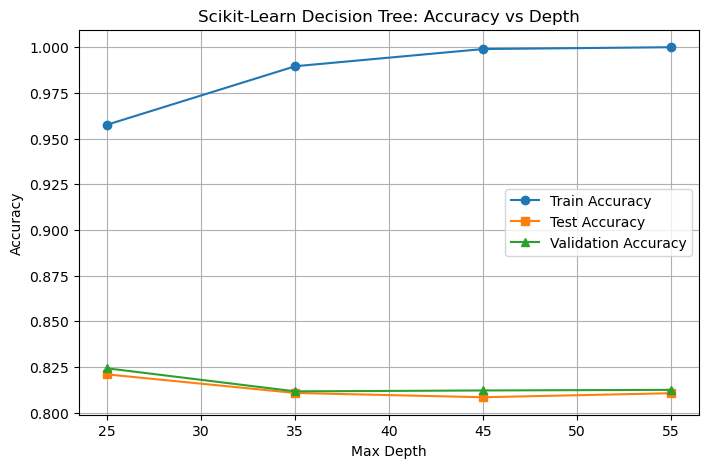

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(depths_d, train_accs_d, marker='o', label='Train Accuracy')
plt.plot(depths_d, test_accs_d, marker='s', label='Test Accuracy')
plt.plot(depths_d, val_accs_d, marker='^', label='Validation Accuracy')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Scikit-Learn Decision Tree: Accuracy vs Depth")
plt.grid(True)
plt.legend()
plt.show()


In [28]:
alphas = [0.001, 0.01, 0.1, 0.2]
train_accs_alpha = []
test_accs_alpha = []
val_accs_alpha = []

for alpha in alphas:
    clf = DecisionTreeClassifier(criterion='entropy', ccp_alpha=alpha, random_state=42)
    clf.fit(train_X_encoded, train_y)

    train_preds = clf.predict(train_X_encoded)
    test_preds = clf.predict(test_X_encoded)
    val_preds = clf.predict(valid_X_encoded)

    train_acc = accuracy_score(train_y, train_preds)
    test_acc = accuracy_score(test_y, test_preds)
    val_acc = accuracy_score(valid_y, val_preds)

    train_accs_alpha.append(train_acc)
    test_accs_alpha.append(test_acc)
    val_accs_alpha.append(val_acc)

    print(f"ccp_alpha={alpha:.3f} → Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Val Acc: {val_acc:.4f}")


ccp_alpha=0.001 → Train Acc: 0.8514, Test Acc: 0.8501, Val Acc: 0.8520
ccp_alpha=0.010 → Train Acc: 0.8397, Test Acc: 0.8392, Val Acc: 0.8424
ccp_alpha=0.100 → Train Acc: 0.7522, Test Acc: 0.7543, Val Acc: 0.7464
ccp_alpha=0.200 → Train Acc: 0.7522, Test Acc: 0.7543, Val Acc: 0.7464


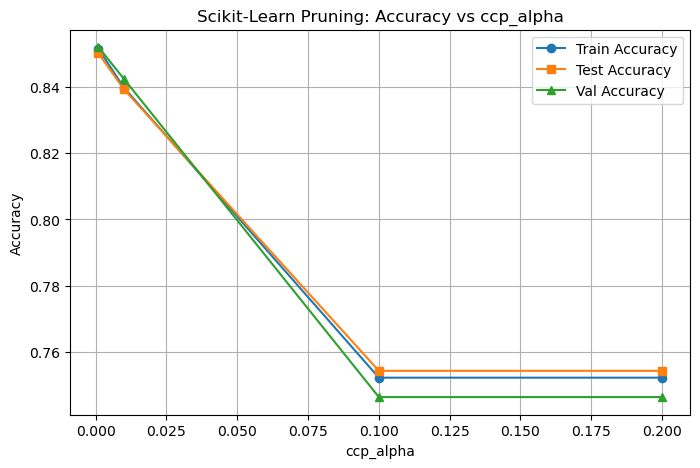

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_accs_alpha, marker='o', label='Train Accuracy')
plt.plot(alphas, test_accs_alpha, marker='s', label='Test Accuracy')
plt.plot(alphas, val_accs_alpha, marker='^', label='Val Accuracy')

plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Scikit-Learn Pruning: Accuracy vs ccp_alpha")
plt.grid(True)
plt.legend()
plt.show()


random forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

In [9]:
param_grid = {
    'n_estimators': [50, 150, 250, 350],
    'max_features': [0.1, 0.3, 0.5, 0.7, 1.0],
    'min_samples_split': [2, 4, 6, 8, 10]
}

best_model = None
best_oob = 0
best_params = None

results = []

for params in ParameterGrid(param_grid):
    clf = RandomForestClassifier(
        criterion='entropy',
        oob_score=True,
        bootstrap=True,
        random_state=42,
        **params
    )
    clf.fit(train_X_encoded, train_y)

    oob_acc = clf.oob_score_
    train_preds = clf.predict(train_X_encoded)
    train_acc = accuracy_score(train_y, train_preds)
    test_preds = clf.predict(test_X_encoded)
    test_acc = accuracy_score(test_y, test_preds)
    val_preds = clf.predict(valid_X_encoded)
    val_acc = accuracy_score(valid_y, val_preds)

    results.append((params, clf, oob_acc, train_acc, test_acc,val_acc))
    if oob_acc > best_oob:
        best_oob = oob_acc
        best_model = clf
        best_params = params

    print(f"Params={params} → OOB Acc={oob_acc:.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, Val Acc={val_acc:.4f}")


Params={'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 50} → OOB Acc=0.8462, Train Acc=0.9996, Test Acc=0.8450, Val Acc=0.8507
Params={'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 150} → OOB Acc=0.8496, Train Acc=1.0000, Test Acc=0.8458, Val Acc=0.8525
Params={'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 250} → OOB Acc=0.8510, Train Acc=1.0000, Test Acc=0.8455, Val Acc=0.8513
Params={'max_features': 0.1, 'min_samples_split': 2, 'n_estimators': 350} → OOB Acc=0.8511, Train Acc=1.0000, Test Acc=0.8454, Val Acc=0.8512
Params={'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 50} → OOB Acc=0.8513, Train Acc=0.9784, Test Acc=0.8483, Val Acc=0.8555
Params={'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 150} → OOB Acc=0.8556, Train Acc=0.9804, Test Acc=0.8504, Val Acc=0.8541
Params={'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 250} → OOB Acc=0.8556, Train Acc=0.9812, Test Acc=0.8491, Val Acc=0.8550
Params={

In [10]:
print("\n Best Parameters:", best_params)

train_acc = accuracy_score(train_y, best_model.predict(train_X_encoded))
val_acc = accuracy_score(valid_y, best_model.predict(valid_X_encoded))
test_acc = accuracy_score(test_y, best_model.predict(test_X_encoded))

print(f"Train Accuracy   : {train_acc:.4f}")
print(f"OOB Accuracy     : {best_model.oob_score_:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy    : {test_acc:.4f}")



 Best Parameters: {'max_features': 0.3, 'min_samples_split': 10, 'n_estimators': 150}
Train Accuracy   : 0.9532
OOB Accuracy     : 0.8599
Validation Accuracy: 0.8589
Test Accuracy    : 0.8556


In [16]:
# Find the entry with the highest validation accuracy
best_val_result = max(results, key=lambda x: x[5])  # x[5] is val_acc

best_val_params = best_val_result[0]
best_val_acc = best_val_result[5]

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"Parameters with Best Validation Accuracy:")
for key, val in best_val_params.items():
    print(f"  {key}: {val}")


Best Validation Accuracy: 0.8603
Parameters with Best Validation Accuracy:
  max_features: 0.7
  min_samples_split: 10
  n_estimators: 350
